In [1]:
#### Rama projektowa - Opisywanie obrazów z wykorzystaniem głębokiego uczenia
#### autorzy: Anna Konieczna, Mateusz Ostrowski

### Rama projektowa
Tutorial: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8 <br>
Zbiór danych: <br>
### Model atencji Transformers
Tutorial: https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/
#### Artykuł:  Attention is all you need https://arxiv.org/pdf/1706.03762.pdf<br>


In [2]:
#### Config
config = { "images_path": "../Flickr8k_Dataset/",
           "train_images_path": "../Flickr8k_text/Flickr_8k.trainImages.txt", # file conatains the names of images to be used in train data
           "test_images_path": "../Flickr8k_text/Flickr_8k.testImages.txt",
           "train_path": "../Flickr8k_text/Flickr_8k.trainImages.txt", 
           "token_path": "../Flickr8k_text/Flickr8k.token.txt",
           "word_embedings_path": "../glove/glove.6B.200d.txt",
           "embedings_dim": 200, # Polish - 100
           "train_model": False, # True if you intend to train the model
           "encode_images": False,
           "pretrained_model_path": "",
           "encoded_images_test": "../Pickle/encoded_test_images.pkl",
           "encoded_images_train": "../Pickle/encoded_train_images.pkl",
           "report_path": "",
           "preprocessed_descriptions_save_path": "descriptions.txt",
           "use_lemma": False,
           "spacy_lemma_model": "pl_spacy_model",
           "lstm_model_save_dir": "../model_weights/",
           "lstm_model_save_path": "../model_weights/model_30.h5"}

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
#from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
#from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

#metric imports
from numpy import mean
import warnings; warnings.simplefilter('ignore')
from IPython.display import clear_output
import nltk
nltk.download('wordnet')

#additionall imports
import pickle
from collections import Counter
from pandas.core.common import flatten

import sys, time, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm

from keras.utils import plot_model

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Load the description set

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

filename = config["token_path"]
# załaduj opisy
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [5]:
# Load the descriptions to dict structure

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [6]:
if config["use_lemma"]:
    import spacy
    nlp = spacy.load('pl_spacy_model')

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      if config["use_lemma"]:
          doc = nlp(desc)
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
# Lematyzacja
#### spacy model from here: http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=view&target=pl_spacy_model-0.1.0.tar.gz
#### spacy dokumentacja - https://spacy.io/usage
      if config["use_lemma"]:
          desc = [word.lemma_ for word in doc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8775


In [8]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, config["preprocessed_descriptions_save_path"])

In [9]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = config["train_path"]
train = load_set(filename)
print('Train Dataset: %d' % len(train))

#load test dataset (1K)
filename = config["test_images_path"]
test = load_set(filename)
print('Test Dataset: %d' % len(test))

Train Dataset: 6000
Test Dataset: 1000


In [10]:
# Below path contains all the images
images = config["images_path"]
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [11]:
# Read the train image names in a set
train_images = set(open(config["train_images_path"], 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [12]:
# Below file conatains the names of images to be used in test data
test_images_file = config["test_images_path"]
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
print('Test images: %d' % len(test_img))

Test images: 1000


In [13]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(config["preprocessed_descriptions_save_path"], train)
test_descriptions = load_clean_descriptions(config["preprocessed_descriptions_save_path"], test)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [14]:
### start of local attention

In [15]:
def load_image(images_path):
   img = tf.io.read_file(images_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, images_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
#encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(train_img)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [17]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

94it [07:33,  4.82s/it]

CPU times: user 1h 4min 27s, sys: 13min 52s, total: 1h 18min 19s
Wall time: 7min 33s


In [18]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
        
all_train_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# Create a list of paths to images for all training captions
img_name_train = []
for key, val in train_descriptions.items():
    for cap in val:
        img_name_train.append(config["images_path"] + key + ".jpg")
        
img_name_train[:10]

['../Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '../Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '../Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '../Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '../Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '../Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '../Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '../Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '../Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 '../Flickr8k_Dataset/1001773457_577c3a7d70.jpg']

In [20]:
# Create a list of all the testing captions
all_test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
        all_test_captions.append(cap)
len(all_test_captions)

5000

In [21]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(all_train_captions)
train_seqs = tokenizer.texts_to_sequences(all_train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(all_train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [22]:
all_train_captions[:3]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq']

In [23]:
train_seqs[:3]

[[3, 2, 44, 5, 2, 89, 172, 8, 119, 57, 2, 396, 13, 397, 5, 29, 4483, 643, 4],
 [3, 2, 20, 316, 66, 2, 198, 120, 4],
 [3, 2, 41, 20, 119, 66, 2, 198, 2061, 4]]

In [ ]:
cap_vector.shape

In [24]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 37 : 4


In [25]:
#img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)
#img_name_train = all_train_captions
#img_name_val = test_img all_test_captions
#cap_train = cap_vector
#cap_val = test_img

In [26]:
cap_train = cap_vector

In [27]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [28]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
# Increase number of epochs to get better caption precision. 
# It increases learning time
for epoch in range(30):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
transformer.save_weights('image_caption_transformer_30.h5')

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

In [36]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [37]:
def final_prediction(result):
    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)


    #remove endseq from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(" ", 1)[0]
    
    return result_final

In [38]:
### end of local attention

In [39]:
# Consider only words which occur at least 10 times in the corpus - TODO: check if worth it
"""
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))
"""

"\nword_count_threshold = 10\nword_counts = {}\nnsents = 0\nfor sent in all_train_captions:\n    nsents += 1\n    for w in sent.split(' '):\n        word_counts[w] = word_counts.get(w, 0) + 1\n\nvocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]\nprint('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))\n"

In [40]:
#TODO: check how to save weights here
#if config["train_model"]:
#    model.save_weights(config["lstm_model_save_path"])

In [41]:
#TODO: check how to load weights here

#model.load_weights(config["lstm_model_save_path"])

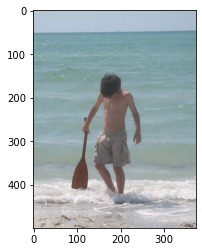


Valid descriptions:
['a boy holding an oar walk through the ocean', 'a boy is carrying a paddle whilst walking through the water on a beach', 'a boy is on the beach with a paddle in his hand as he walks through the ocean water', 'a boy with an oar walks out of the surf and onto a beach', 'a little boy walks with a paddle out into the sand']

Local attention: a young boy in swim trunks is walking in the ocean


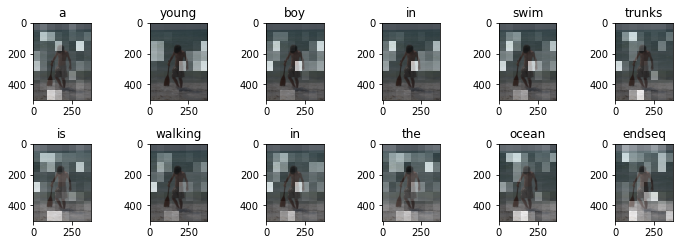

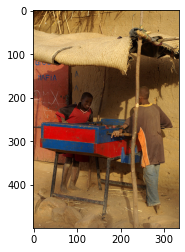


Valid descriptions:
['two children standing under an awning', 'two kids are playing a game of foosball', 'two kids in a developing nation are playing a table top game under an awning made from burlap', 'two men play a game beneath a shade', 'two young kids are in a hut']

Local attention: a young man in a red and brown dog


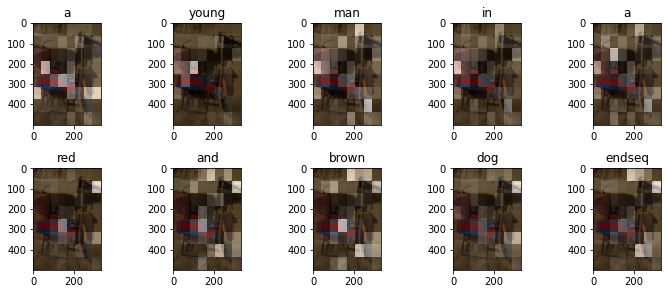

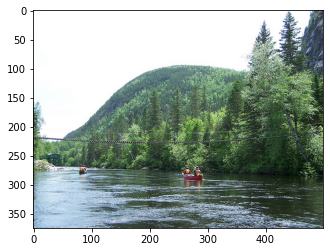


Valid descriptions:
['a kayak on the river is passing by a wire bridge that joins both banks', 'some people ride their kayaks down the river', 'two conoes float down the river', 'two groups are canoeing on a river overlooking a mountain', 'two people rafting down a river a footbridge in the background']

Local attention: a red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red red


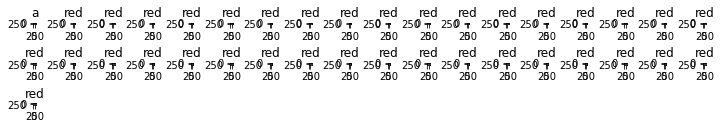

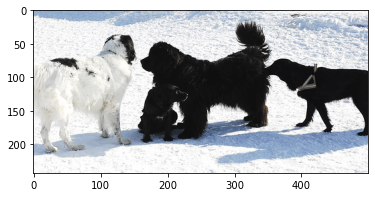


Valid descriptions:
['a group of dogs stand in the snow', 'four dogs stand in the snow', 'three black dogs and a white dog are standing in the snow', 'two black dogs a black puppy and a white dog in the snow', 'two large black dogs one small black dog and one large white dog are standing in some snow']

Local attention: two dogs are playing in the snow


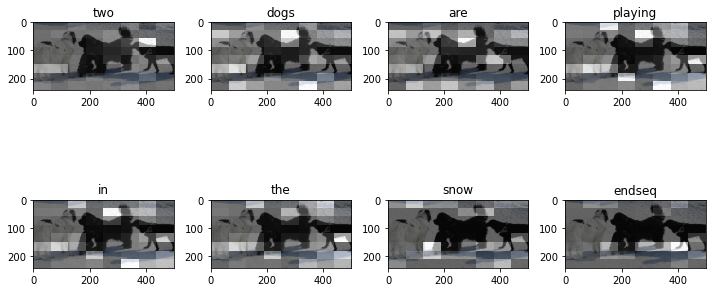

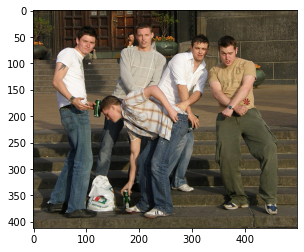


Valid descriptions:
['a group of young men clowning around while enjoying a beverage', 'five men pose awkwardly on steps', 'five young men pose on the steps', 'four boys posing while one boy sets his drink down', 'group of young men posing and holding cans']

Local attention: four people standing on a bench


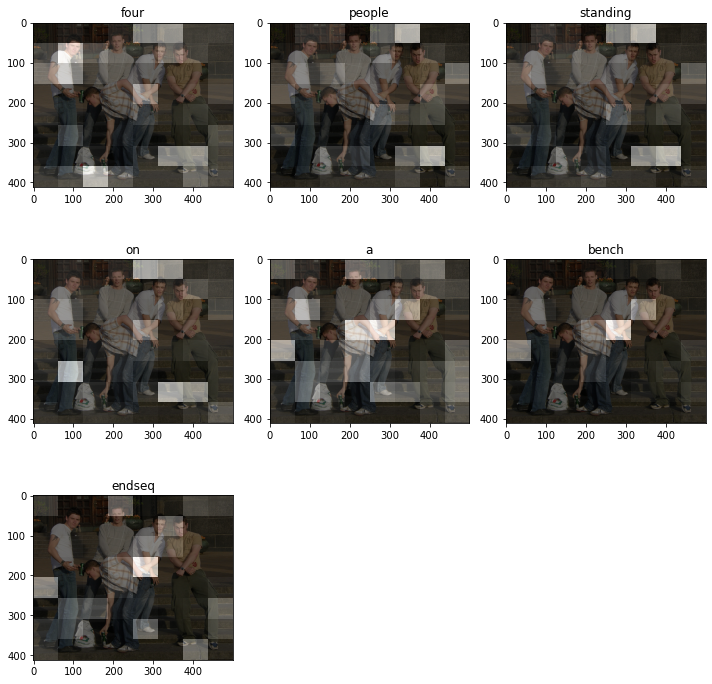

In [42]:
#### Results
for i in range(0,5):
    pic = test_img[i]
    x = np.array(Image.open(pic))
    #get image name from image path
    img_name = pic.split('/')[2].split('.')[0]
    plt.imshow(x)
    plt.show()
    print("\nValid descriptions:")
    print(descriptions[img_name])
    
    result,output,attention_weights = evaluate(pic)
    
    print("\nLocal attention:", final_prediction(result))
    #plot_attention(pic, result, attention_plot)


In [43]:
#### Metrics
##### Cider
#function for calculating cider metric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cider(given_captions, prediction):
    prediction_arr = []
    prediction_arr.append(prediction)
    vectorizer = TfidfVectorizer()
    trainedV = vectorizer.fit(given_captions)
    givenTfIdf = trainedV.transform(given_captions).toarray()
    predTfIdf = trainedV.transform(prediction_arr).toarray()
    partialCiders = 0
    help_arr = []
    
    for c in givenTfIdf:
        help_arr.append(c)
        partialCiders = partialCiders + cosine_similarity(predTfIdf,help_arr)
        help_arr = []
        
    return partialCiders/len(givenTfIdf)

In [44]:
#preparation of metrics lists
bleu_train_scores = []
meteor_train_scores = []
cider_train_scores = []
    
for i in range(0,5):
    bleu_train_scores.append([])
    meteor_train_scores.append([])
    cider_train_scores.append([])

    #calculation of metrics for train images dataset
    for j in range(0,len(train_img)):
        pic = train_img[j]

        actual_desc_0 = descriptions[pic.split('/')[2].split('.')[0]][0]
        actual_desc_1 = descriptions[pic.split('/')[2].split('.')[0]][1]
        actual_desc_2 = descriptions[pic.split('/')[2].split('.')[0]][2]
        actual_desc_3 = descriptions[pic.split('/')[2].split('.')[0]][3]
        actual_desc_4 = descriptions[pic.split('/')[2].split('.')[0]][4]
        
        result,output,attention_weights = evaluate(pic)
        bleu_train_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split(), actual_desc_2.split(),
                 actual_desc_3.split(), actual_desc_4.split()],
                final_prediction(result).split())
        )
        meteor_train_scores[i].append(meteor_score(descriptions[pic.split('/')[2].split('.')[0]],final_prediction(result)))
        cider_train_scores[i].append(cider(descriptions[pic.split('/')[2].split('.')[0]],final_prediction(result))[0][0])

        clear_output(wait=True)
        print('train',i,j, flush=True)

result_data_tren = {}

#calculate mean score based on socres list for each metric
for i in range(0,5):
    result_data_tren[str(i)] = [
        mean(bleu_train_scores[i]),
        mean(meteor_train_scores[i]),
        mean(cider_train_scores[i]),
    ]

result = pd.DataFrame.from_dict(
    result_data_tren,
    orient='index',
    columns=['Bleu TREN','Meteor TREN','CIDEr TREN']
)

result

train 4 5999


,Bleu TREN,Meteor TREN,CIDEr TREN
0,0.221799,0.479871,0.292304
1,0.221799,0.479871,0.292304
2,0.221799,0.479871,0.292304
3,0.221799,0.479871,0.292304
4,0.221799,0.479871,0.292304


In [45]:
#preparation of metrics lists
bleu_test_scores = []
meteor_test_scores = []
cider_test_scores = []
    
for i in range(0,5):

    bleu_test_scores.append([])
    meteor_test_scores.append([])
    cider_test_scores.append([])

    #calculation of metrics for test images dataset
    for j in range(0,len(test_img)):
        pic = test_img[j]

        actual_desc_0 = descriptions[pic.split('/')[2].split('.')[0]][0]
        actual_desc_1 = descriptions[pic.split('/')[2].split('.')[0]][1]
        actual_desc_2 = descriptions[pic.split('/')[2].split('.')[0]][2]
        actual_desc_3 = descriptions[pic.split('/')[2].split('.')[0]][3]
        actual_desc_4 = descriptions[pic.split('/')[2].split('.')[0]][4]

        result,output,attention_weights = evaluate(pic)
        bleu_test_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split(), actual_desc_2.split(),
                 actual_desc_3.split(), actual_desc_4.split()],
                final_prediction(result).split())
        )
        meteor_test_scores[i].append(meteor_score(descriptions[pic.split('/')[2].split('.')[0]],final_prediction(result)))
        cider_test_scores[i].append(cider(descriptions[pic.split('/')[2].split('.')[0]],final_prediction(result))[0][0])

        clear_output(wait=True)
        print('test',i,j, flush=True)


result_data_test = {}

#calculate mean score based on socres list for each metric
for i in range(0,5):
    result_data_test[str(i)] = [
        mean(bleu_test_scores[i]),
        mean(meteor_test_scores[i]),
        mean(cider_test_scores[i])
    ]

result = pd.DataFrame.from_dict(
    result_data_test,
    orient='index',
    columns=['Bleu TEST','Meteor TEST', 'CIDEr TEST']
)

result

test 4 999


,Bleu TEST,Meteor TEST,CIDEr TEST
0,0.048575,0.307017,0.218505
1,0.048575,0.307017,0.218505
2,0.048575,0.307017,0.218505
3,0.048575,0.307017,0.218505
4,0.048575,0.307017,0.218505


In [48]:
#calculate mean score based on socres list for each metric


for i in range(0,5):
    result_data_test[str(i)] = [
        mean(bleu_test_scores[i]),
        mean(meteor_test_scores[i]),
        mean(cider_test_scores[i])
    ]

result = pd.DataFrame.from_dict(
    result_data_test,
    orient='index',
    columns=['Bleu TEST', 'Meteor TEST', 'CIDEr TEST']
)

result

,Bleu TEST,Meteor TEST,CIDEr TEST
0,0.048575,0.307017,0.218505
1,0.048575,0.307017,0.218505
2,0.048575,0.307017,0.218505
3,0.048575,0.307017,0.218505
4,0.048575,0.307017,0.218505
